In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, single_electron as se
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Single tone fit

In this notebook I look at what the influence is of the slope of the electron mode frequency $\Delta f/\Delta V$. The slope will determine the mode frequency around the crossing point and we'll see that it sets the width of the phase feature. The other parameters are the coupling $g$ and the qubit linewidth $\Gamma$.

I'll first look at the how the phase response changes for different $g$ when $\Gamma$ and the slope are fixed. Next I'll do the same for $\Gamma$ and the other two fixed. Lastly, I vary $\Delta f/\Delta V$ and keep the other two variables constant.

In [2]:
# this assumes kappa ~ 0.5 kappa_in + 0.5 kappa_out (no internal loss)
f_cavity = 6.397E9
detunings = np.linspace(-1.0E6, 1.0E6, 151)
detuning_std = 300e3 #kappa_tot
f_drive = f_cavity + detunings
Q_cavity = 20E3
kappa_tot = f_cavity / Q_cavity
Vtrap = np.linspace(0.160, 0.230, 10000)

## Phase response for different $g$ at constant $\Gamma$, $\Delta f/\Delta V$

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 4857
/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


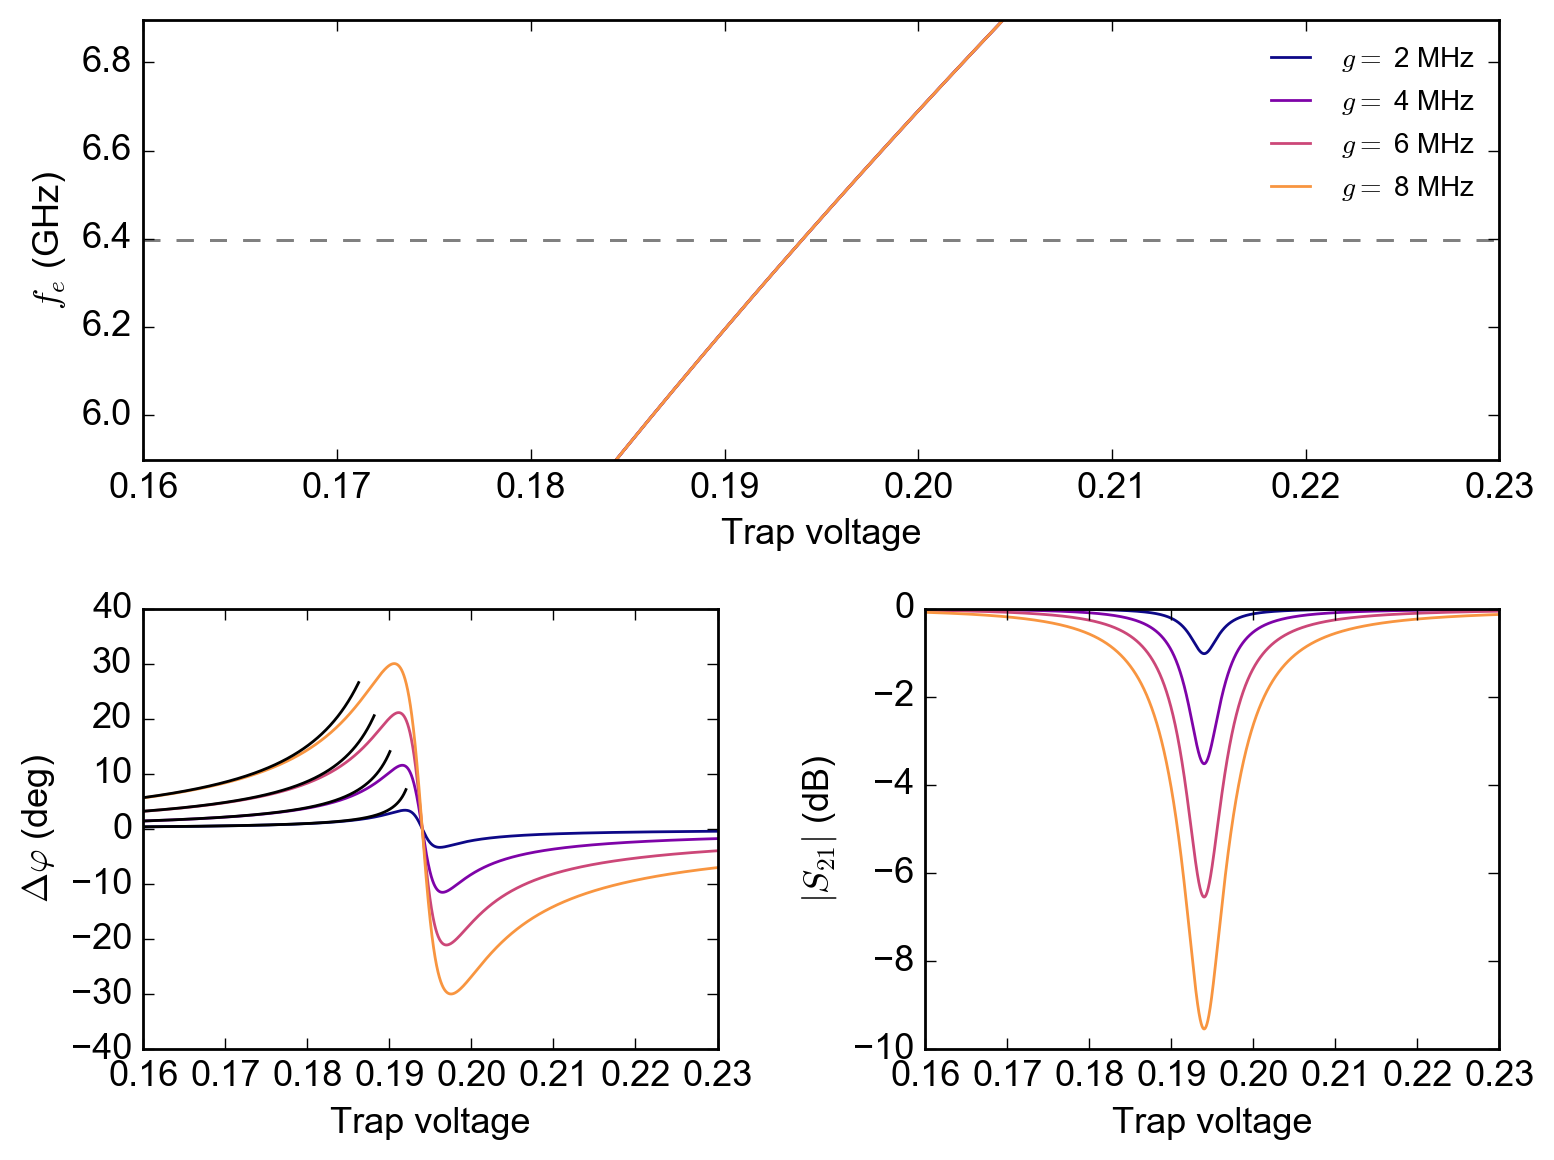

In [3]:
g_guesses = np.arange(2e6, 10E6, 2E6)
gamma_guesses = 100E6 * np.ones(len(g_guesses))
derivative_guess = 50E9 # Hz/V
V_crossing_guess = 0.194 # V

span = 1000e6

fig = plt.figure(figsize=(8.,6.))
common.configure_axes(13)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)

for jj, g_guess in enumerate(g_guesses):
    gamma_guess = gamma_guesses[jj]
    qubit_freq = se.voltage_to_frequency_from_derivative(Vtrap, V_crossing=V_crossing_guess, 
                                                         f_cavity=f_cavity, derivative=derivative_guess)

    ax1.plot(Vtrap, 1/1E9 * qubit_freq, color=common.rgb(jj, len(g_guesses), cmap=plt.cm.plasma), 
             label="$g = $ %.0f MHz" % (g_guess/1e6))
    ax1.set_xlabel("Trap voltage")
    ax1.set_ylabel("$f_e$ (GHz)")
    ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))
    ax1.hlines(f_cavity / 1E9, np.min(Vtrap), np.max(Vtrap), linestyles='--', color='gray')
    ax1.set_ylim((f_cavity - span/2.)/1e9, (f_cavity + span/2.)/1e9)
    ax1.legend(loc=0, prop={"size" : 10}, frameon=False)

    s21_mag, s21_phi = se.s21(kappa_tot=kappa_tot, g=g_guess, f_cavity=f_cavity, f_drive=f_cavity, 
                              f_electron=qubit_freq, gamma=gamma_guess)
    dispersive_phase_shift = np.arctan(1 / kappa_tot * g_guess ** 2 / (f_cavity - qubit_freq) ) * 180/np.pi
    valid = g_guess / (f_cavity - qubit_freq[qubit_freq < f_cavity]) < 1/50.
    
    
    ax2.plot(Vtrap, s21_phi * 180/np.pi, label="", color=common.rgb(jj, len(g_guesses), cmap=plt.cm.plasma))
    ax2.plot(Vtrap[valid], dispersive_phase_shift[valid], '-k')
    ax2.set_xlabel("Trap voltage")
    ax2.set_ylabel(r"$\Delta \varphi$ (deg)")
    ax2.legend(loc=0, prop={"size" : 10}, frameon=False)
    ax2.set_xlim(np.min(Vtrap), np.max(Vtrap))

    ax3.plot(Vtrap, 20 * np.log10(s21_mag), label="", color=common.rgb(jj, len(g_guesses), cmap=plt.cm.plasma))
    ax3.set_xlabel("Trap voltage")
    ax3.set_ylabel(r"$|S_{21}|$ (dB)")
    ax3.legend(loc=0, prop={"size" : 10}, frameon=False)
    ax3.set_xlim(np.min(Vtrap), np.max(Vtrap))

fig.tight_layout()

All plots above are taken at fixed $\Delta f/\Delta V$ and $\Gamma$. Changing $g$ increases both the _width_, as well as the _strength_ of the phase signal. The black lines in the left plot are what you would expect from a dispersive phase shift. You can see that the dispersive shift is already quite accurate not far from the voltage crossing point. 

## Phase response for different $\Gamma$ at constant $g$, $\Delta f/\Delta V$

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


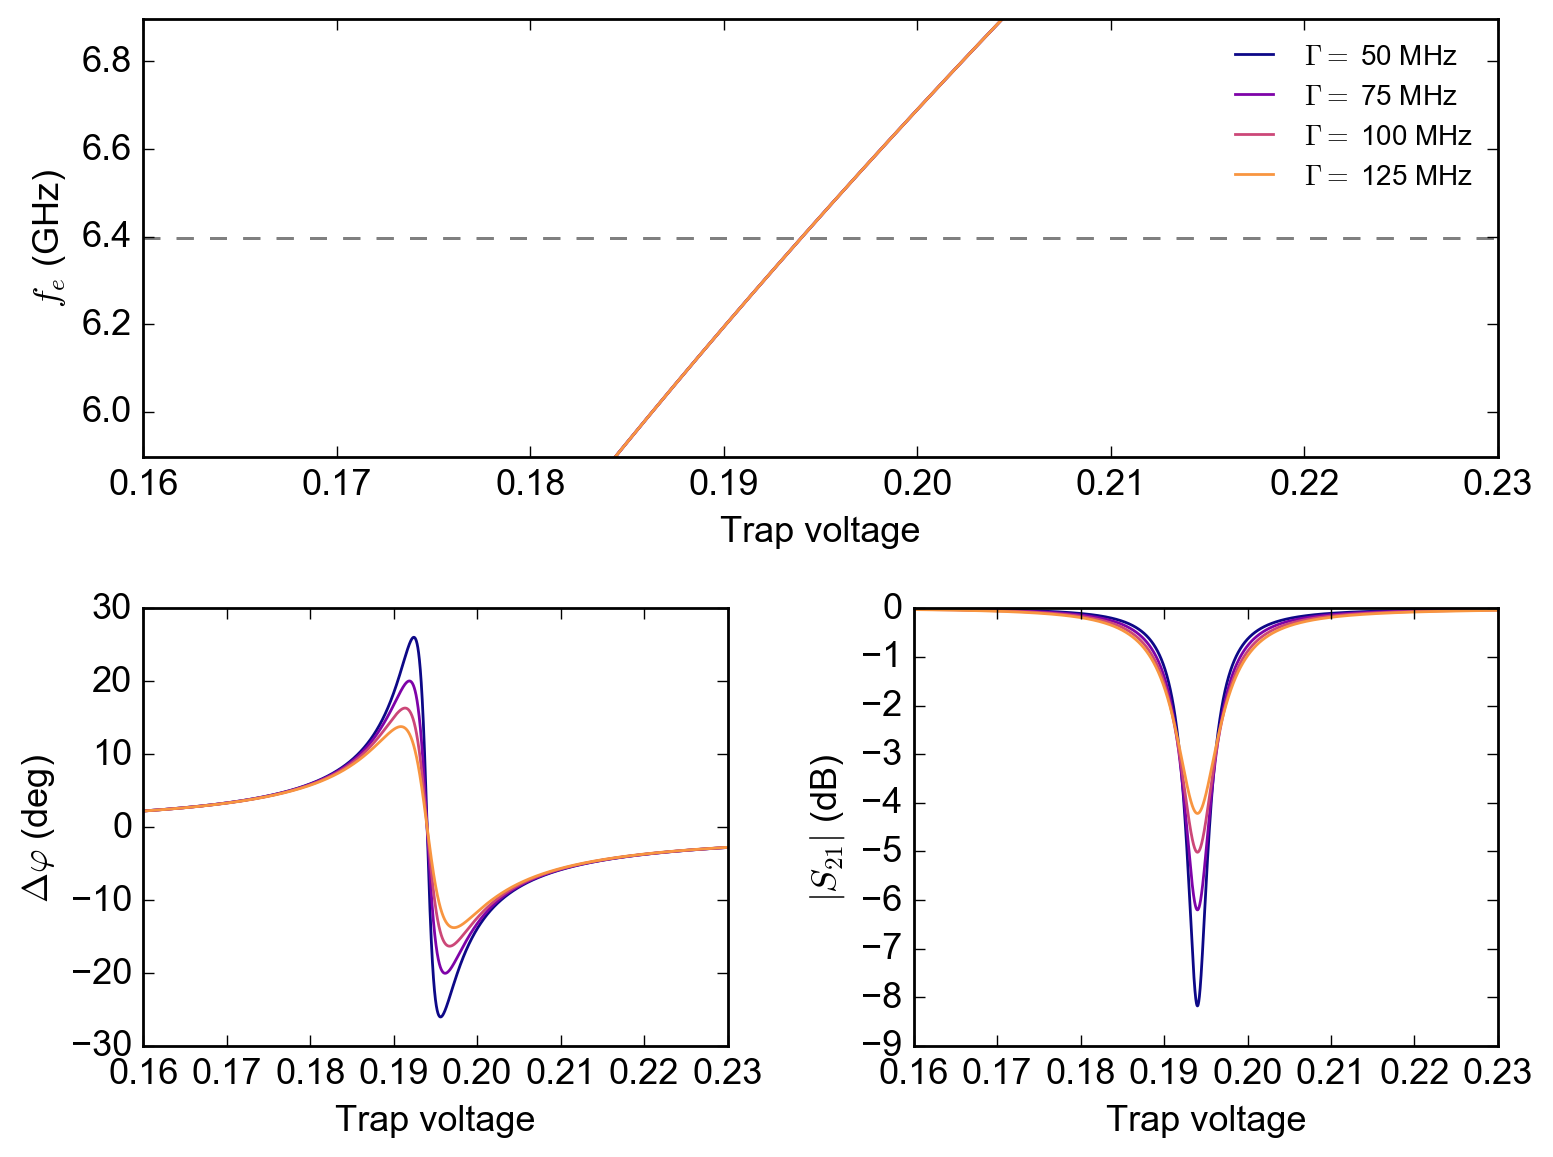

In [4]:
gamma_guesses = np.arange(50E6, 150E6, 25E6)
g_guesses = 5E6 * np.ones(len(gamma_guesses)) #0.03 * gamma_guesses #
derivative_guess = 50E9 # Hz/V
V_crossing_guess = 0.194 # V

span = 1000e6

fig = plt.figure(figsize=(8.,6.))
common.configure_axes(13)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)

for jj, gamma_guess in enumerate(gamma_guesses):
    g_guess = g_guesses[jj]
    qubit_freq = se.voltage_to_frequency_from_derivative(Vtrap, V_crossing=V_crossing_guess, 
                                                         f_cavity=f_cavity, derivative=derivative_guess)

    ax1.plot(Vtrap, 1/1E9 * qubit_freq, color=common.rgb(jj, len(gamma_guesses), cmap=plt.cm.plasma), 
             label="$\Gamma = $ %.0f MHz" % (gamma_guess/1e6))
    ax1.set_xlabel("Trap voltage")
    ax1.set_ylabel("$f_e$ (GHz)")
    ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))
    ax1.hlines(f_cavity / 1E9, np.min(Vtrap), np.max(Vtrap), linestyles='--', color='gray')
    ax1.set_ylim((f_cavity - span/2.)/1e9, (f_cavity + span/2.)/1e9)
    ax1.legend(loc=0, prop={"size" : 10}, frameon=False)

    s21_mag, s21_phi = se.s21(kappa_tot=kappa_tot, g=g_guess, f_cavity=f_cavity, f_drive=f_cavity, 
                              f_electron=qubit_freq, gamma=gamma_guess)

    ax2.plot(Vtrap, s21_phi * 180/np.pi, label="", color=common.rgb(jj, len(gamma_guesses), cmap=plt.cm.plasma))
    ax2.set_xlabel("Trap voltage")
    ax2.set_ylabel(r"$\Delta \varphi$ (deg)")
    ax2.legend(loc=0, prop={"size" : 10}, frameon=False)
    ax2.set_xlim(np.min(Vtrap), np.max(Vtrap))

    ax3.plot(Vtrap, 20 * np.log10(s21_mag), label="", color=common.rgb(jj, len(gamma_guesses), cmap=plt.cm.plasma))
    ax3.set_xlabel("Trap voltage")
    ax3.set_ylabel(r"$|S_{21}|$ (dB)")
    ax3.legend(loc=0, prop={"size" : 10}, frameon=False)
    ax3.set_xlim(np.min(Vtrap), np.max(Vtrap))

fig.tight_layout()

The plots above are for a constant $\Delta f/\Delta V$ and a constant coupling $g$. For an increasing $\Gamma$, we see an increase in the signal _width_ as well as an increase in the signal _strength_

## Phase response for different $\Delta f/\Delta V$ at constant $\Gamma$, $g$

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/gkoolstra/Documents/Code/TrapAnalysis/single_electron.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * derivative * f_cavity * (V - V_crossing) + f_cavity ** 2)


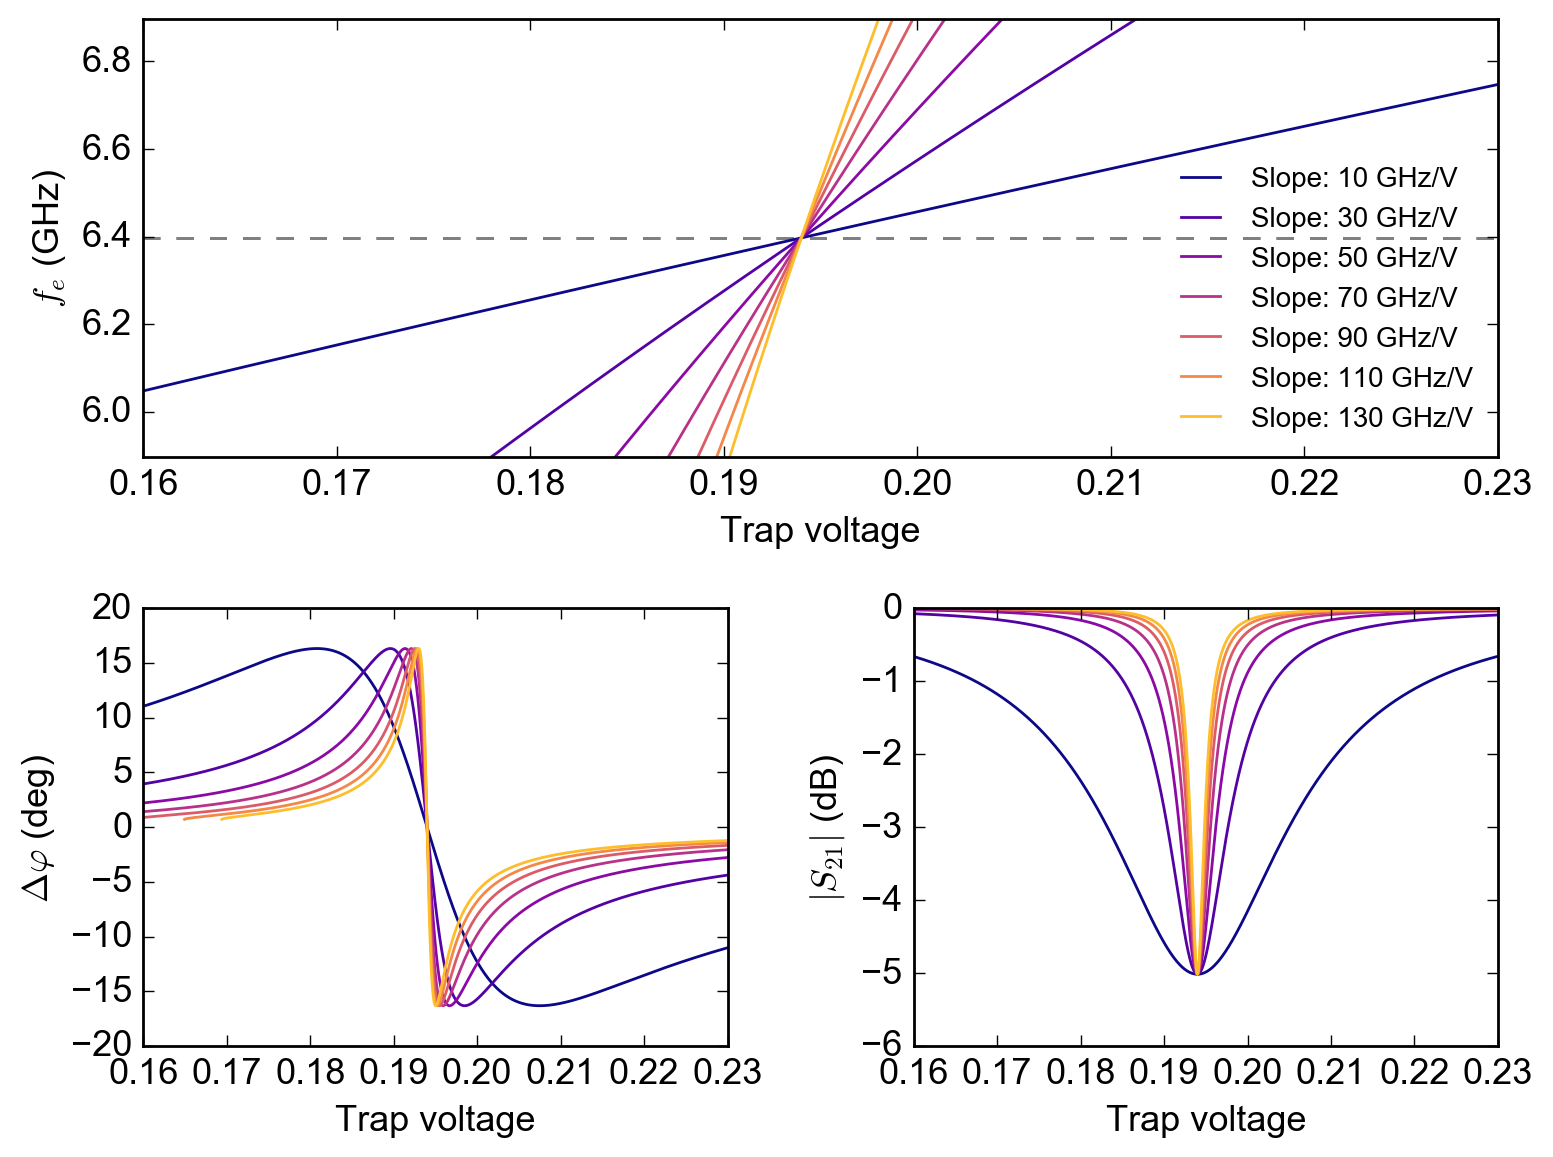

In [5]:
g_guess = 5E6
gamma_guess = 100E6
derivative_guesses = np.arange(10E9, 150E9, 20E9) # Hz/V
V_crossing_guess = 0.194 # V

span = 1000e6

fig = plt.figure(figsize=(8.,6.))
common.configure_axes(13)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)

for jj, derivative_guess in enumerate(derivative_guesses):

    qubit_freq = se.voltage_to_frequency_from_derivative(Vtrap, V_crossing=V_crossing_guess, 
                                                         f_cavity=f_cavity, derivative=derivative_guess)

    ax1.plot(Vtrap, 1/1E9 * qubit_freq, color=common.rgb(jj, len(derivative_guesses), cmap=plt.cm.plasma), 
             label="Slope: %.0f GHz/V" % (derivative_guess/1e9))
    ax1.set_xlabel("Trap voltage")
    ax1.set_ylabel("$f_e$ (GHz)")
    ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))
    ax1.hlines(f_cavity / 1E9, np.min(Vtrap), np.max(Vtrap), linestyles='--', color='gray')
    ax1.set_ylim((f_cavity - span/2.)/1e9, (f_cavity + span/2.)/1e9)
    ax1.legend(loc=0, prop={"size" : 10}, frameon=False)

    s21_mag, s21_phi = se.s21(kappa_tot=kappa_tot, g=g_guess, f_cavity=f_cavity, f_drive=f_cavity, 
                              f_electron=qubit_freq, gamma=gamma_guess)

    ax2.plot(Vtrap, s21_phi * 180/np.pi, label="", color=common.rgb(jj, len(derivative_guesses), cmap=plt.cm.plasma))
    ax2.set_xlabel("Trap voltage")
    ax2.set_ylabel(r"$\Delta \varphi$ (deg)")
    ax2.legend(loc=0, prop={"size" : 10}, frameon=False)
    ax2.set_xlim(np.min(Vtrap), np.max(Vtrap))

    ax3.plot(Vtrap, 20 * np.log10(s21_mag), label="", color=common.rgb(jj, len(derivative_guesses), cmap=plt.cm.plasma))
    ax3.set_xlabel("Trap voltage")
    ax3.set_ylabel(r"$|S_{21}|$ (dB)")
    ax3.legend(loc=0, prop={"size" : 10}, frameon=False)
    ax3.set_xlim(np.min(Vtrap), np.max(Vtrap))

fig.tight_layout()

The plots above are for a constant coupling $g$ and qubit linewidth $\Gamma$. As the slope increases, the signal becomes _more narrow_ and the strength of the signal actaully stays _constant_. This means that we have now found the influence of the three fitparameters. Here is the list: 
* Increasing $\Gamma$ will increase the width and decrease the phase swing
* Increasing $g$ will increase the width and increase the phase swing
* Increasing the slope $\Delta f/\Delta V$ will decrease the width and do nothing to the phase swing. It _does_ determine the value off-resonance, since that value is set by $$g^2/\Delta = g^2/(f_e - f_0) \approx \frac{g^2}{\Delta f/\Delta V (V-V_\mathrm{crossing}) - f_0}$$

## Try to fit sample data with the derivative as a fit parameter

The fitting method below takes in the slope as a fit parameter, as well as $g$ and $\Gamma$ and the voltage crossing point $V_0$. We add some noise to the data, and the fit works well, but that is because the data is generated from the same function as the fit function. In practice, this fit method seems very sensitive to the offset, because as stated above the offset determines both the slope and $g$ in the fit. It was worth a try, but we still need to constrain the fit further by measuring the slope from experiment and feed that knowledge back into the fit. This will give us the most accurate fitresult of $g$ and $\Gamma$.

/Users/gkoolstra/Documents/Code/TrapAnalysis/single_electron.py:33: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * derivative * f_cavity * (V - V_crossing) + f_cavity ** 2)


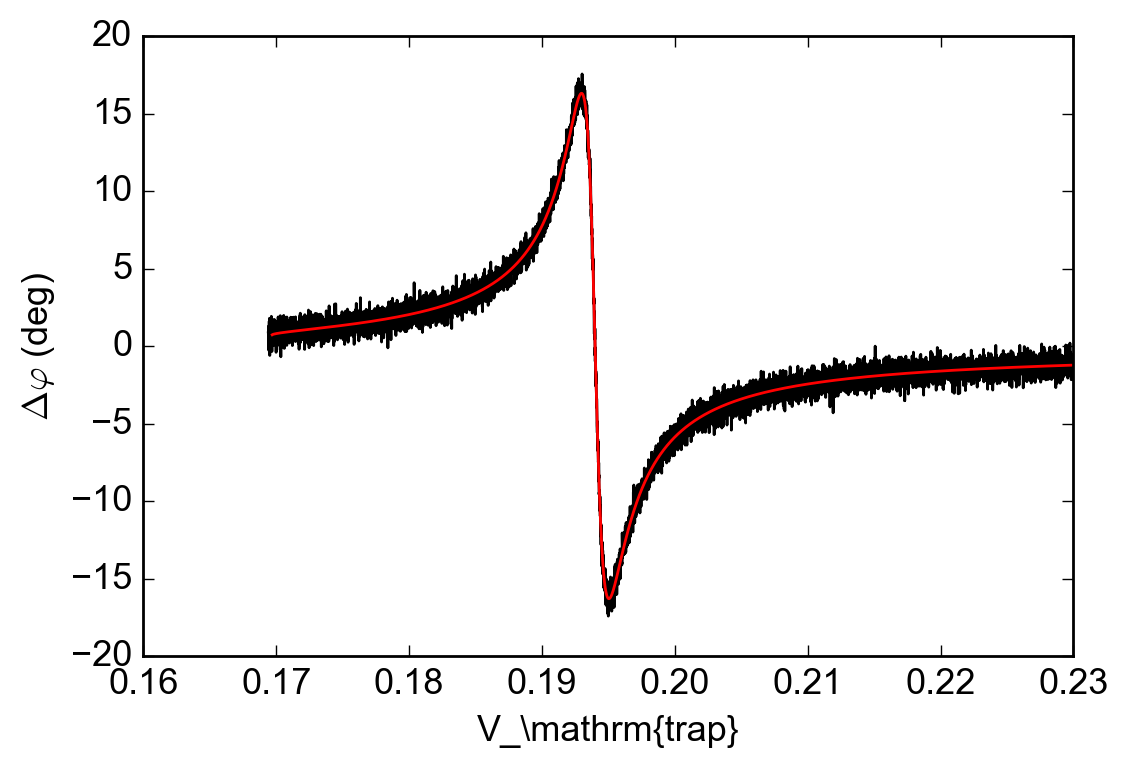

In [36]:
xdata = Vtrap
ydata = s21_phi * 180/np.pi + 0.5*np.random.randn(len(Vtrap))

plt.plot(xdata, ydata, '-k')
fr, ferr = se.fit_phase(xdata, ydata, f_cavity=f_cavity, f_drive=f_cavity, kappa_cavity=kappa_tot, 
                        domain=(0.185, 0.220))
plt.plot(xdata, se.phase_function(xdata, f_cavity, f_cavity, kappa_tot, *fr), '-r')
plt.xlim(np.min(xdata), np.max(xdata))
plt.xlabel("V_\mathrm{trap}")
plt.ylabel(r"$\Delta \varphi$ (deg)")